In [1]:
#STEP 1 IMPORT

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_profiling


from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
from datetime import datetime 
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, brier_score_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, f1_score, log_loss, average_precision_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Описания полей

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [3]:
#STEP 2 ЧТЕНИЕ ДАННЫХ
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


# FUNCTION

In [4]:
# check IQR
def iqr(dt, cl, pr=None):
    IQR = dt.loc[:, cl].quantile(0.75) - dt.loc[:, cl].quantile(0.25)
    perc25 = dt.loc[:, cl].quantile(0.25)
    perc75 = dt.loc[:, cl].quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    if pd.isnull(pr):
        return [IQR, perc25, perc75, lb, hb, dt.loc[:, cl].max(), dt.loc[:, cl].min(), cl]
    else:
        print(cl,
              '25-й перцентиль: {},'.format(perc25),
              '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR),
              "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))

In [5]:
# plot one hist to check outliers closer or just to look deeper

# tit - hist title
# rhb - reviewed highest border in 'Здравый смысл'
# rlb - reviewed lowest border in 'Здравый смысл'
# one of rhb or rlb could be missed

def hist_check(dth, b, tit, rhb=None, rlb=None):
    IQR = dth.quantile(0.75) - dth.quantile(0.25)
    perc25 = dth.quantile(0.25)
    perc75 = dth.quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))

    fig = plt.figure()
    dth.loc[dth.between(
        lb,
        hb)].hist(bins=b, label='IQR')

    if rlb != None and rhb != None:
        dth.loc[(rlb <= dth) & (dth <= rhb)].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rlb) and rhb != None:
        dth.loc[dth <= rhb].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rhb) and rlb != None:
        dth.loc[rlb <= dth].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')

    plt.legend()
    plt.title(tit)
    return [lb, hb]

In [6]:
def pre_model(data, submission = False):
    train_data = data.query('sample == 1').drop(['sample'], axis=1)
    test_data = data.query('sample == 0').drop(['sample'], axis=1)
    
    prediction = test_data.copy()
    
    train_data.drop('client_id', axis=1, inplace=True)
    test_data.drop('client_id', axis=1, inplace=True)

    y = train_data.default.values            # наш таргет
    X = train_data.drop(['default'], axis=1)

    RANDOM_SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    logModel = LogisticRegression(max_iter = 10000)
    logModel.fit(X_train, y_train)
    y_pred = logModel.predict(X_test)

    probs = logModel.predict_proba(X_test)
    prob = probs[:,1]
    
    scores(y_test, y_pred, prob)
    
    if submission:
        submission_ = pd.concat([prediction.client_id,pd.Series(prob,name='default')],axis=1)
        submission_.to_csv('submission.csv', index=False)
    
    return (roc_auc, submission_)

In [7]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [8]:
# calculating scores function
def scores(y_test, y_pred, prob):
    fpr, tpr, threshold = roc_curve(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    print ("f1_score:",round(f1_score(y_test,y_pred), 3))
    print ("accuracy_score:",round(accuracy_score(y_test,y_pred), 3))
    print ("precision_score:",round(precision_score(y_test,y_pred), 3))
    print ("recall_score:",round(recall_score(y_test,y_pred), 3))
    print ("log_loss:",round(log_loss(y_test,y_pred), 3))
    print ("roc_auc_score:",round(roc_auc, 3))
    print("average_precision_score:", round(average_precision_score(y_test,y_pred), 3))
    print("brier_score_loss:", round(brier_score_loss(y_test,y_pred), 3))
    print('Confusion matrix:\n{}' .format(confusion_matrix(y_test,y_pred)))
    return (roc_auc)

# EDA

In [9]:
df_train.info()
# education содержит пустые значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
#STEP 3 объединяем обучающий и тестовый набор

# заполним пока в целевую функцию 0
df_test['default'] = 0

# создадим столбец чтобы различать обучающую и тестовый набор
df_train['sample'] = 1
df_test['sample'] = 0

# объединяем обучающий и тестовый набор, чтобы применять одинаковую обработку 
data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.head()
data.shape

(110148, 20)

In [12]:
# закачаем pandas profiling report
#data_rep = pandas_profiling.ProfileReport(data) 
#data_rep.to_file('data_report.html')
#на каггле не отрабатывает, виснит на 70%. Поэтому отчет запустила в юпитере

1. В базе достаточно мало пропущенных значени (< 0.1)

2. client_id - числовой, все значения уникальны, можно удалить
3. app_date - чаще всего повторяются 5 дат: 18MAR2014, 19MAR2014, 17MAR2014, 31MAR2014, 07APR2014
4. education - имеет пропуски 478 значений (0.4%), половина из которых SCH, можно им и заполнить пропуски
5. sex - бинарный, без пропусков
6. age - числовой, с правым хвостом. МОжно прологорифмировать, чтобы привести к нормальному распределению
7. car - бинарный, сильно связан с car_type
8. car_type - бинарный, сильно связан с car. Попробовать убрать один из (car, car_type)
9. decline_app_cnt - 83% имеют значение 0, можно попробовать редкие значения заменить правой границей выбороса
10. good_work - бинарный, без пропусков
11. score_bki - имеет нормальное распределение, отрицательные значения
12. bki_request_cnt - 26.2% имеют значение 0, можно попробовать редкие значения заменить правой границей выбороса
13. region_rating - по названию ординарный, без пропусков
14. home_address - категориальный, сильно связан с work_address
15. work_address - категориальный, сильно связан с home_address.  Попробовать убрать один из (home_address, work_address)
16. income - числовой, с выбросами (экстремально низкими и высокими значениями). Попробуем сделать производный столбец с категорией. Выбросы заменить на границы.
17. sna  - категориальный, сильно связан с first_time
18. first_time  - категориальный, сильно связан с sna.  Попробовать убрать один из (sna, first_time)
19. foreign_passport - бинарный
20. default - категориальный, целевой. 0	 91.5%. Дибаланс выборки, требуется underfitting/overfitting

In [13]:
# step 4
#client_id - идентификатор клиента
#education - уровень образования
#sex - пол заемщика
#age - возраст заемщика
#car - флаг наличия автомобиля
#car_type - флаг автомобиля иномарки
#decline_app_cnt - количество отказанных прошлых заявок
#good_work - флаг наличия “хорошей” работы
#bki_request_cnt - количество запросов в БКИ
#home_address - категоризатор домашнего адреса
#work_address - категоризатор рабочего адреса
#income - доход заемщика
#foreign_passport - наличие загранпаспорта
#sna - связь заемщика с клиентами банка
#first_time - давность наличия информации о заемщике
#score_bki - скоринговый балл по данным из БКИ
#region_rating - рейтинг региона
#app_date - дата подачи заявки
# бинарные переменные - имеют 2 значения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['home_address', 'work_address', 'sna','first_time']
# числовые переменные
num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
num_cols_p2 = ['score_bki']
# ординарные переменные - ранжируются
ord_cols = ['education','region_rating']

# РАБОТАЕМ С БИНАРНЫМИ ПЕРЕМЕННЫМИ

In [14]:
# проверим что бинарные переменные действительно бинарные
for x in bin_cols:
    cnt = Counter(data[x])
    if (len(list(cnt)) > 2) : # количество уникальных элементов
        print(len(list(cnt)),'x')        
# все ок

In [15]:
# step 5
# Применим LabelEncoder ко всему набору бинарных переменных.
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


# РАБОТАЕМ С КАТЕГОРИАЛЬНЫМИ ПЕРЕМЕННЫМИ

In [16]:
# step 6
# категориальные переменные 
#cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'day_week', 'is_weekend']
# app_date попробуем поработать с ней

data['app_date'] = data['app_date'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y').date())
data['day_week'] = data['app_date'].apply(lambda x: x.isoweekday()) #день недели в виде числа, понедельник - 1, воскресенье - 7 слабая значимость уберу пока
data['is_weekend'] = np.where(data['day_week'].isin([6,7]), 1 , 0) 
cat_cols = cat_cols + ['day_week','is_weekend']
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,day_week,is_weekend
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,...,1,2,50000,1,4,0,0,0,6,1
1,17527,2014-01-24,SCH,0,39,0,0,5,0,-1.504999,...,1,2,5000,4,3,0,0,0,5,0
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,...,1,2,30000,1,3,1,0,0,7,1
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,...,1,2,17000,1,3,0,0,0,1,0
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,...,2,3,120000,1,3,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,0,45,0,0,0,0,-1.792064,...,1,2,17000,4,4,0,0,1,2,0
110144,76821,2014-03-24,SCH,1,41,1,1,0,0,-2.058029,...,2,2,70000,1,4,0,0,1,1,0
110145,103695,2014-04-22,SCH,1,31,0,0,0,0,-1.512635,...,2,3,45000,2,2,0,0,1,2,0
110146,861,2014-01-04,SCH,0,29,0,0,0,1,-1.479334,...,1,3,13000,2,3,0,1,1,6,1


is_weekend          0.000007
day_week            0.000041
sex                 0.000106
car                 0.000630
good_work           0.000662
car_type            0.001181
foreign_passport    0.001578
work_address        0.002271
home_address        0.002808
first_time          0.003558
sna                 0.004829
dtype: float64

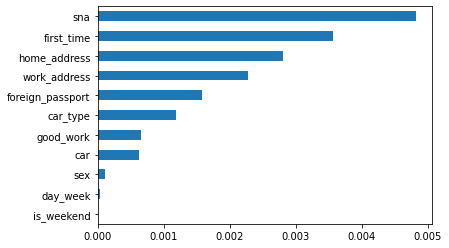

In [17]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
imp_cat

In [18]:
# step 7 для One-Hot Encoding в pandas функция - get_dummies для преобразования категориальных переменных
#df_train = pd.get_dummies(df_train, columns = cat_cols, dummy_na=False)

# РАБОТАЕМ С ЧИСЛОВЫМИ ПЕРЕМЕННЫМИ

In [19]:
# проверим выбросы
al = []
for col in num_cols_p1 + num_cols_p2:
    al.append(iqr(data, col))
    
# find columns with outliers => NaN in outlier column
all_borders = pd.DataFrame(al, columns=['IQR', 'perc25', 'perc75', 'lb', 'hb', 'max_v', 'min_v', 'df_train'])
all_borders.loc[(all_borders.hb >= all_borders.max_v) & (all_borders.lb <= all_borders.min_v), 'outlier'] = 'no'
all_borders['outlier'].fillna('yes', inplace=True)
all_borders

# выбросы есть, вернемся к ним позже

,IQR,perc25,perc75,lb,hb,max_v,min_v,df_train,outlier
0,18.000000,30.000000,48.000000,3.000000,75.00000,72.000000,21.000000,age,no
1,0.000000,0.000000,0.000000,0.000000,0.00000,33.000000,0.000000,decline_app_cnt,yes
2,28000.000000,20000.000000,48000.000000,-22000.000000,90000.00000,1000000.000000,1000.000000,income,yes
3,3.000000,0.000000,3.000000,-4.500000,7.50000,53.000000,0.000000,bki_request_cnt,yes
4,0.692546,-2.260434,-1.567888,-3.299252,-0.52907,0.199773,-3.624586,score_bki,yes


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


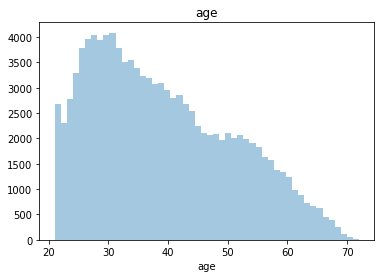

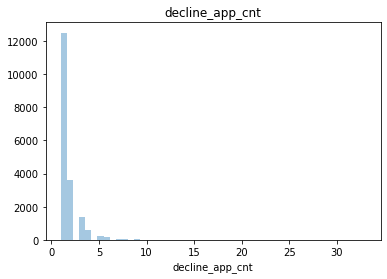

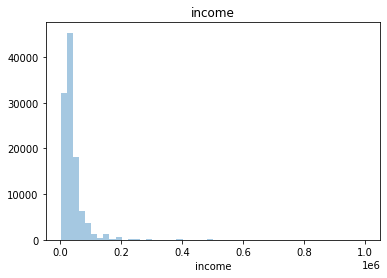

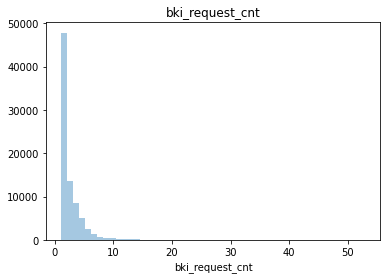

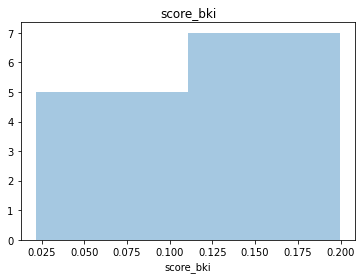

In [20]:
#num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
#num_cols_p2 = ['score_bki']
for i in num_cols_p1 + num_cols_p2:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [21]:
# step 7
# теперь задача прологорифмировать числовые переменные, со 'score_bki' поработаем отдельно
data[num_cols_p1] = data[num_cols_p1].apply(lambda w: np.log(w + 1))
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,day_week,is_weekend
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,1,2,10.819798,1,4,0,0,0,6,1
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,1,2,8.517393,4,3,0,0,0,5,0
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,1,2,10.308986,1,3,1,0,0,7,1
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,1,2,9.741027,1,3,0,0,0,1,0
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,2,3,11.695255,1,3,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,0,3.828641,0,0,0.000000,0,-1.792064,...,1,2,9.741027,4,4,0,0,1,2,0
110144,76821,2014-03-24,SCH,1,3.737670,1,1,0.000000,0,-2.058029,...,2,2,11.156265,1,4,0,0,1,1,0
110145,103695,2014-04-22,SCH,1,3.465736,0,0,0.000000,0,-1.512635,...,2,3,10.714440,2,2,0,0,1,2,0
110146,861,2014-01-04,SCH,0,3.401197,0,0,0.000000,1,-1.479334,...,1,3,9.472782,2,3,0,1,1,6,1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


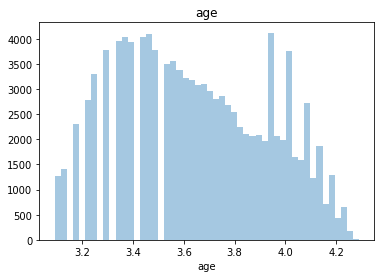

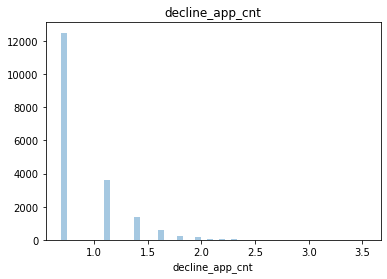

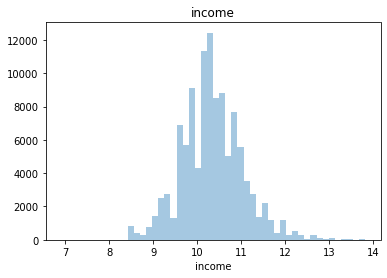

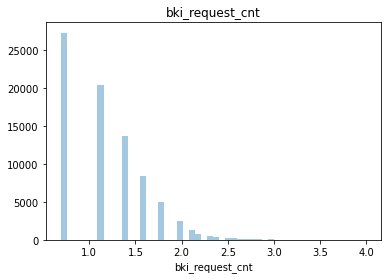

In [22]:
for i in num_cols_p1:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [23]:
# step 8
# поработаем со 'score_bki'  отдельно
data['score_bki_abs'] = data['score_bki'].apply(lambda w: np.log(abs(w) + 1)) # возьмем по модулю 
data['score_bki_pow'] = data['score_bki'].apply(lambda w: w ** 2) # возьмем по модулю 
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,sample,day_week,is_weekend,score_bki_abs,score_bki_pow
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,10.819798,1,4,0,0,0,6,1,1.185366,5.161455
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,8.517393,4,3,0,0,0,5,0,0.918288,2.265022
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,10.308986,1,3,1,0,0,7,1,0.990039,2.860628
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,9.741027,1,3,0,0,0,1,0,1.216153,5.636742
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,11.695255,1,3,0,0,0,2,0,1.249186,6.187668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,0,3.828641,0,0,0.000000,0,-1.792064,...,9.741027,4,4,0,0,1,2,0,1.026781,3.211495
110144,76821,2014-03-24,SCH,1,3.737670,1,1,0.000000,0,-2.058029,...,11.156265,1,4,0,0,1,1,0,1.117771,4.235484
110145,103695,2014-04-22,SCH,1,3.465736,0,0,0.000000,0,-1.512635,...,10.714440,2,2,0,0,1,2,0,0.921332,2.288064
110146,861,2014-01-04,SCH,0,3.401197,0,0,0.000000,1,-1.479334,...,9.472782,2,3,0,1,1,6,1,0.907990,2.188428


# РАБОТАЕМ С ОРДИНАРНЫМИ ПЕРЕМЕННЫМИ

UNK - неизвестно 0 ровень
SCH - школа - 1 уровень
UGR - undergraduated - бакалавриат - 2 уровень
GRD - graduated - магистр, высшее образование - 3 уровень
PGR - postgraduated- аспирантура - 4 уровень
ACD - academic - докторантура - 5 уровень. 

In [24]:
#STEP 9 
# ординарные переменные - ранжируются
# ord_cols = ['education','region_rating']

#education
#пропуски только в поле education, заполним категорие = неизвестно 'UNK'
data['education'].fillna('UNK', inplace=True)

edu = {'SCH': 1, 'UGR': 2, 'GRD': 3,  'PGR': 4, 'ACD': 5, 'UNK':0}
data['education'] = data['education'].map(edu)

In [25]:
data.corr().default.sort_values()

score_bki_abs      -0.141279
score_bki_pow      -0.133408
first_time         -0.084394
region_rating      -0.071729
education          -0.066674
foreign_passport   -0.052770
car_type           -0.046586
income             -0.043099
good_work          -0.035126
car                -0.034999
client_id          -0.030812
age                -0.020045
day_week            0.000546
is_weekend          0.003849
sex                 0.014580
bki_request_cnt     0.062350
work_address        0.064733
home_address        0.068008
decline_app_cnt     0.100564
sna                 0.101171
score_bki           0.139777
sample              0.214022
default             1.000000
Name: default, dtype: float64

<AxesSubplot:>

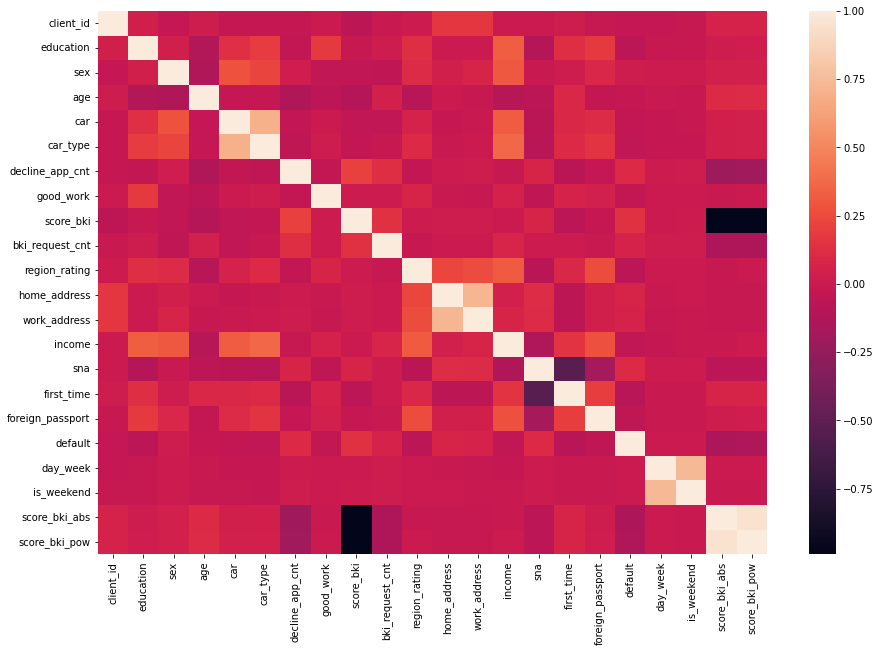

In [26]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr())

# CLEAR

In [27]:
#STEP 10 удаляем лишние колонки

# client_id 
# проверим, если нет повторений то врядли полезен
#data.client_id.value_counts().loc[lambda x: x > 1]
#повторений нет, наверно удалим пока
data.drop('client_id', axis=1, inplace=True)

# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

data

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,income,sna,first_time,foreign_passport,default,sample,day_week,is_weekend,score_bki_abs,score_bki_pow
0,3,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,...,10.819798,1,4,0,0,0,6,1,1.185366,5.161455
1,1,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,...,8.517393,4,3,0,0,0,5,0,0.918288,2.265022
2,2,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,...,10.308986,1,3,1,0,0,7,1,0.990039,2.860628
3,1,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,...,9.741027,1,3,0,0,0,1,0,1.216153,5.636742
4,3,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,...,11.695255,1,3,0,0,0,2,0,1.249186,6.187668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,3,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,...,9.741027,4,4,0,0,1,2,0,1.026781,3.211495
110144,1,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,...,11.156265,1,4,0,0,1,1,0,1.117771,4.235484
110145,1,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,...,10.714440,2,2,0,0,1,2,0,0.921332,2.288064
110146,1,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,...,9.472782,2,3,0,1,1,6,1,0.907990,2.188428


In [28]:
# код основного прогона, без всяких изысканий
# наивная модель 
#STEP 1 IMPORT + function (прогоняем в начале)

#STEP 2 ЧТЕНИЕ ДАННЫХ
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

#STEP 3 объединяем обучающий и тестовый набор
# заполним пока в целевую функцию 0
df_test['default'] = 0
# создадим столбец чтобы различать обучающую и тестовый набор
df_train['sample'] = 1
df_test['sample'] = 0
# объединяем обучающий и тестовый набор, чтобы применять одинаковую обработку 
data = df_test.append(df_train, sort=False).reset_index(drop=True)

# step 4
# бинарные переменные - имеют 2 значения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['home_address', 'work_address', 'sna','first_time']
# числовые переменные
num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
num_cols_p2 = ['score_bki']
# ординарные переменные - ранжируются
ord_cols = ['education','region_rating']

# step 5 бинарные переменные
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# step 6 категориальные переменные 
#cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'day_week', 'is_weekend']
data['app_date'] = data['app_date'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y').date())
data['day_week'] = data['app_date'].apply(lambda x: x.isoweekday()) #день недели в виде числа, понедельник - 1, воскресенье - 7 
data['is_weekend'] = np.where(data['day_week'].isin([6,7]), 1 , 0) 
cat_cols = cat_cols + ['is_weekend']

# step 7 num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
# теперь задача прологорифмировать числовые переменные, со 'score_bki' поработаем отдельно
data[num_cols_p1] = data[num_cols_p1].apply(lambda w: np.log(w + 1))
data

# step 8
# поработаем со 'score_bki'  отдельно
data['score_bki_abs'] = data['score_bki'].apply(lambda w: np.log(abs(w) + 1)) # возьмем по модулю 
data['score_bki_pow'] = data['score_bki'].apply(lambda w: w ** 2) # возьмем по модулю 

#STEP 9 ординарные переменные - ранжируются
# ord_cols = ['education','region_rating']
#пропуски только в поле education, заполним категорие = неизвестно 'UNK'
data['education'].fillna('UNK', inplace=True)
edu = {'SCH': 1, 'UGR': 2, 'GRD': 3,  'PGR': 4, 'ACD': 5, 'UNK':0}
data['education'] = data['education'].map(edu)

#STEP 10 удаляем лишние колонки

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

#roc_auc, submission  = pre_model(data, submission = True)
#roc_auc 0.7388534508892215 наивная модель 

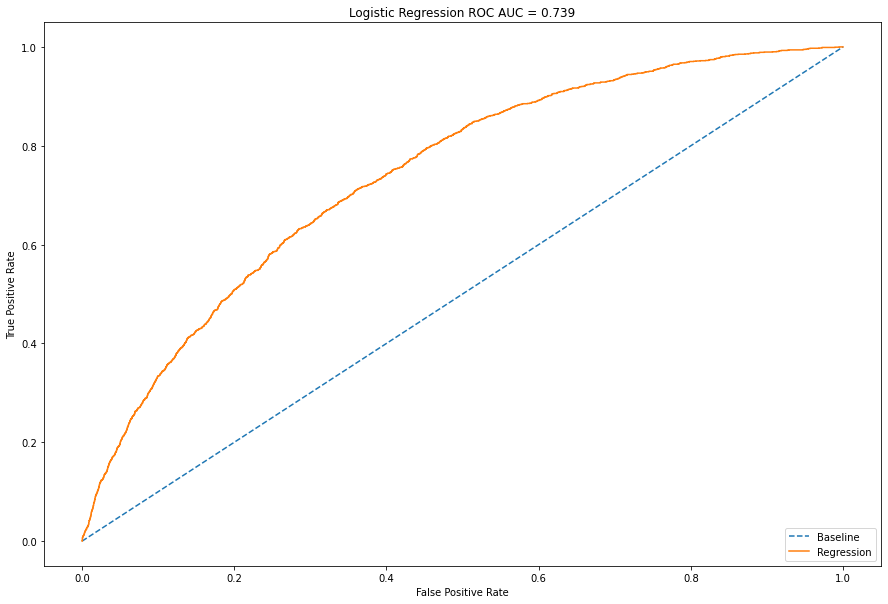

f1_score: 0.038
accuracy_score: 0.875
precision_score: 0.414
recall_score: 0.02
log_loss: 4.31
roc_auc_score: 0.739
average_precision_score: 0.129
brier_score_loss: 0.125
Confusion matrix:
[[12882    51]
 [ 1791    36]]


0.7388534508892215

In [29]:
    train_data = data.query('sample == 1').drop(['sample'], axis=1)
    test_data = data.query('sample == 0').drop(['sample'], axis=1)
    
    test_data = test_data.drop(['default'], axis=1)
    prediction = test_data.copy()
    
    train_data.drop('client_id', axis=1, inplace=True)
    test_data.drop('client_id', axis=1, inplace=True)

    y = train_data.default.values            # наш таргет
    X = train_data.drop(['default'], axis=1)

    RANDOM_SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    logModel = LogisticRegression(max_iter = 10000)
    logModel.fit(X_train, y_train)
    y_pred = logModel.predict(X_test)

    probs = logModel.predict_proba(X_test)
    prob = probs[:,1]
    
    scores(y_test, y_pred, prob)
    


In [30]:
test_data

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,day_week,is_weekend,score_bki_abs,score_bki_pow
0,3,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,6,1,1.185366,5.161455
1,1,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,5,0,0.918288,2.265022
2,2,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,7,1,0.990039,2.860628
3,1,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,1,0,1.216153,5.636742
4,3,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,2,0,1.249186,6.187668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,1,0,3.637586,0,0,0.693147,0,-1.744976,1.386294,50,2,3,9.615872,4,1,0,1,0,1.009772,3.044940
36345,3,0,4.174387,1,1,0.000000,0,-2.293781,1.386294,60,1,2,12.206078,1,4,0,5,0,1.192036,5.261433
36346,3,1,3.465736,0,0,1.098612,0,-0.940752,0.693147,50,1,2,11.002117,4,2,0,7,1,0.663075,0.885014
36347,2,0,3.332205,0,0,0.693147,0,-1.242392,1.098612,80,2,3,10.308986,1,1,0,2,0,0.807543,1.543537


In [31]:
probs_sub = logModel.predict_proba(test_data)
probs_sub = probs_sub[:,1]

submission = pd.concat([prediction.client_id,pd.Series(probs_sub,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)

In [32]:
submission

,client_id,default
0,74835,0.047279
1,17527,0.334540
2,75683,0.067617
3,26883,0.086427
4,28862,0.022231
...,...,...
36344,83775,0.365524
36345,106254,0.023436
36346,81852,0.343286
36347,1971,0.183435
